<hr style="border:2px solid gray"> </hr>

<centre>
    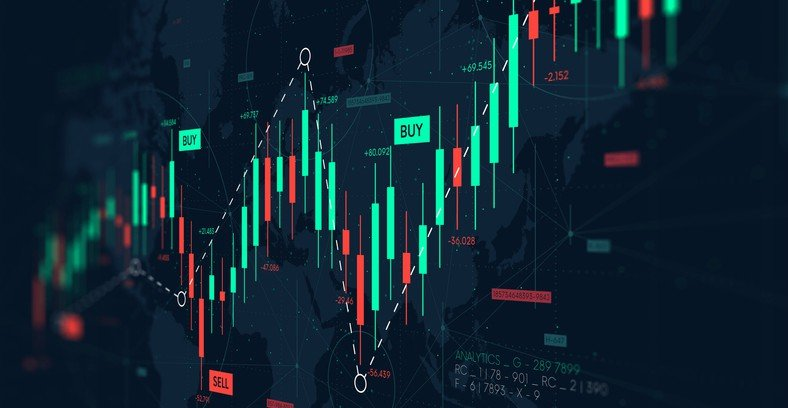
</centre>

<hr style="border:2px solid gray"> </hr>

# Automated Web Application for predicting high impact Forex Economic News Release

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis and Prediction](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem

All types of traders (as well as business and multinational firms) stated before now are affected by the periodic release of economic parameters, which give insight into the state of an economy. For traders like periodic news traders, this effect can be instantaneous, but for economic traders, technical traders and multinational firms, these news releases and their trends can have extended effects spanning for weeks, months or even years. This is where foresight becomes important, because being able to predict a news parameter beforehand could help a trader take an early positon in the market, or being able to determine the trend of a certain economy using its parameters could be crucial during business projections

## Data

This project was majorly focused on the prediction of the periodic value of the bank rate set by the Federal Market Open Committee (FOMC) of the United States of America. The dataset used in this notebook was extracted from a preloaded IBM DB2 database, and was gotten from a website known as forex factory, which focuses on monthly economic news releases of different economies. This website was used due to its consistency and accuracy, as well as it’s availability. However, the concept of the project isn’t limited to this particular website, as any other effective website can be used for the same purpose with a little change of code. https://www.forexfactory.com/calendar?month=this

The data extraction and preparation process will be divided into two phases
- [Conecting to Database]
- [Extraction and Wrangling of Data]

In [ ]:
!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa
!pip install ipython-sql

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import ibm_db
import ibm_db_dbi
import copy

%load_ext sql

### - Connecting to Database

In [4]:
%sql ibm_db_sa:

In [1]:
dsn_hostname = ""
dsn_uid = ""  
dsn_pwd = "" 

dsn_driver = "{}"
dsn_database = ""          
dsn_port = ""                
dsn_protocol = ""

In [2]:
#Create the dsn connection string
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

In [ ]:
#Create database connection

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

In [8]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

### - Extraction and Wrangling of Data

In [ ]:
#Calling up the list of table in the database.
%sql select TABSCHEMA, TABNAME, CREATE_TIME from SYSCAT.TABLES \
      where TABSCHEMA not in ('SYSIBM', 'SYSCAT', 'SYSSTAT', 'SYSIBMADM', 'SYSTOOLS', 'SYSPUBLIC')

In [10]:
#Extracting the date to be predicted for.
selectQuery = 'select * from US_FOMC_FUTURE_DATES'
future_date = pd.read_sql(selectQuery, pconn)

pred_date = future_date.iloc[0,0] 
print(pred_date)

2021-06-16


In [ ]:
#Extracting the dependent parameter from the database
label = %sql select * from US_FOMC_RATES
label = pd.DataFrame(label, columns = ['Date', 'Time', 'US_FOMC_RATES'])
label.dropna(axis=0, inplace=True)

label

In [12]:
#Applying data transformation and feature engineering on the date columns so as to be able to index the dataframe later on.
label['Year'] = pd.to_datetime(label['Date']).dt.year.astype('str') 
label['Month'] = pd.to_datetime(label['Date']).dt.month.astype('str')
label['Date_time'] = label['Year']+'-'+label['Month']
label['Date'] = label['Date'].astype('str')+' '+label['Time'].astype('str')

label['Date'] = pd.to_datetime(label['Date'])
label['Date'] = label['Date'].values.astype(np.int64) // 10 ** 9
label.drop(['Year','Month', 'Time'], 1, inplace=True)

In [13]:
label.head()

,Date,US_FOMC_RATES,Date_time
0,1170201600,0.0525,2007-1
1,1174435200,0.0525,2007-3
2,1178668800,0.0525,2007-5
3,1182988800,0.0525,2007-6
4,1186444800,0.0525,2007-8


In [14]:
#Creating a copy of the dependent parameter dataframe that will be used for the prediction.
label1 = copy.deepcopy(label)
label1.drop(['Date'], 1, inplace=True)
label1.head()

,US_FOMC_RATES,Date_time
0,0.0525,2007-1
1,0.0525,2007-3
2,0.0525,2007-5
3,0.0525,2007-6
4,0.0525,2007-8


In [15]:
#Call up the most recent date from the dependent parameter dataframe, which will be used to index the independent features dataframe later on.
last_date = max(label['Date'].values)
last_date

1623870000

In [17]:
#Extracting the independent parameter from the database separately due to their separate arrangement in the database, and assigning them to a dictionary for easy reference, 
#and splitting later on.
features = ['US_TRADE_BALANCE', 'US_UNEMPLOYMENT_RATES']
features_dict = {}
for feature in features:
    selectQuery = 'select * from '+ feature #Construct the query that retrieves all rows from the INSTRUCTOR table
    features_dict[feature] = pd.read_sql(selectQuery, pconn) #Execute the statement
    features_dict[feature].columns = ['Date', 'Time', feature]
    features_dict[feature].dropna(axis=0, inplace=True)

In [18]:
#Applying data transformation and feature engineering on the date columns so as to be able to index the dataframe later on.
for value in features_dict.values():
    value['Year'] = pd.to_datetime(value['Date']).dt.year.astype('str') 
    value['Month'] = pd.to_datetime(value['Date']).dt.month.astype('str')
    value['Date_time'] = value['Year']+'-'+value['Month']
    value['Date'] = value['Date'].astype('str')+' '+value['Time'].astype('str')
    value.drop(['Year','Month','Time'], 1, inplace=True)    

In [19]:
features_dict['US_TRADE_BALANCE'].head(2)

,Date,US_TRADE_BALANCE,Date_time
0,2010-03-11 00:00:00,-37.3,2010-3
1,2010-04-13 00:00:00,-39.7,2010-4


In [20]:
features_dict['US_UNEMPLOYMENT_RATES'].head(2)

,Date,US_UNEMPLOYMENT_RATES,Date_time
0,2010-03-05 00:00:00,0.09699999999999999,2010-3
1,2010-04-02 00:00:00,0.09699999999999999,2010-4


In [21]:
print(features_dict['US_TRADE_BALANCE'].shape, features_dict['US_UNEMPLOYMENT_RATES'].shape)

(136, 3) (136, 3)


In [22]:
#Indexing the independent features dataframe, so as to use all the data that were released before the most recent date of the dependent feature for training and testing.
features_train = copy.deepcopy(features_dict)
for value in features:
    features_train[value]['Date'] = pd.to_datetime(features_train[value]['Date'])
    features_train[value]['Date'] = features_train[value]['Date'].values.astype(np.int64) // 10 ** 9
    features_train[value] = features_train[value].loc[features_train[value]['Date'] <= last_date]

In [23]:
print(features_train['US_TRADE_BALANCE'].shape, features_train['US_UNEMPLOYMENT_RATES'].shape)

(136, 3) (136, 3)


In [129]:
#Indexing the independent features dataframe, so as to use all the data that were released after the most recent date of the dependent feature for inference. 
features_predict = copy.deepcopy(features_dict)
for value in features:
    features_predict[value]['Date'] = pd.to_datetime(features_predict[value]['Date'])
    features_predict[value]['Date'] = features_predict[value]['Date'].values.astype(np.int64) // 10 ** 9
    features_predict[value] = features_predict[value].loc[features_predict[value]['Date'] > last_date]

In [130]:
print(features_predict['US_TRADE_BALANCE'])
print(features_predict['US_UNEMPLOYMENT_RATES'])

         Date  US_TRADE_BALANCE Date_time
0  1623159000             -68.9    2021-6
1  1620135000             -74.4    2021-5
           Date  US_NFP_RATES Date_time
0    1620394200         0.061    2021-5
135  1622813400         0.057    2021-6


In [131]:
#Irrelevant columns are dropped.
for value in features_predict.values():
    value.drop(['Date','Date_time'], 1, inplace=True)

In [132]:
#Excess data is merged in preparation for the inference.
for value in features:
    if features_predict[value].size > 1:
        new_value = np.mean(features_predict[value].values)
        features_predict[value] = pd.DataFrame({value:[new_value]})
    else:
        continue

In [133]:
print(features_predict['US_TRADE_BALANCE'])
print(features_predict['US_UNEMPLOYMENT_RATES'])

   US_TRADE_BALANCE
0            -71.65
   US_NFP_RATES
0         0.059


In [134]:
#Finally the separate inference dataframes are merged to one final inference dataframe.
dataset_pred = pd.concat(features_predict.values(), axis=1)
dataset_pred

,US_TRADE_BALANCE,US_NFP_RATES
0,-71.65,0.059


In [137]:
for value in features_train.values():
    value.reset_index(inplace=True, drop=True)
    value.drop('Date', 1, inplace=True)

In [143]:
features_train['US_TRADE_BALANCE'].head(2)

,US_TRADE_BALANCE,Date_time
0,-71.1,2021-4
1,-68.2,2021-3


In [144]:
features_train['US_UNEMPLOYMENT_RATES'].head(2)

,US_NFP_RATES,Date_time
0,0.060,2021-4
1,0.062,2021-3


In [140]:
#The separate dataframes for independent features are concatenated and duplicate columns are dropped, in preparation for the final training and testing dataframe.
dataset_train = pd.concat(features_train.values(), axis=1)
dataset_train = dataset_train.loc[:,~dataset_train.columns.duplicated()] #Get rid of duplicate columns
dataset_train.head()

,US_TRADE_BALANCE,Date_time,US_NFP_RATES
0,-71.1,2021-4,0.060
1,-68.2,2021-3,0.062
2,-66.6,2021-2,0.063
3,-68.1,2021-1,0.067
4,-63.1,2020-12,0.067


In [141]:
#The concatenated datarames of the independent features are now merged with the dataframe containing the dependent feature to produce a final dataframe,
#that would be used for testing and training of the algorithm to be used.
dataset_train = dataset_train.merge(label1, on='Date_time', how='inner')
dataset_train.drop('Date_time', 1, inplace=True)        

In [142]:
dataset_train

,US_TRADE_BALANCE,US_NFP_RATES,US_FOMC_RATES
0,-71.1,0.060,0.0025
1,-68.2,0.062,0.0025
2,-68.1,0.067,0.0025
3,-63.1,0.067,0.0025
4,-63.9,0.069,0.0025
...,...,...,...
86,-42.8,0.096,0.0025
87,-49.9,0.095,0.0025
88,-40.3,0.097,0.0025
89,-39.7,0.097,0.0025


## Methodology

In this section of the project, a supervised machine learning algorithm (Decision tree) was applied on the final selected features, and subsequently used for the inference. As earlier stated, the dependent parameter for this phase of the project was largely categorical, hence a classification model was most suited for the prediction, also due to the fact that slightest deviation in this type of parameter prediction nullifies its usefulness, hence getting a regression model with high accuracy would still be less useful than a classification model because of the residues that comes with regression models. 

## Analysis and Prediction

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [146]:
N = dataset_train.iloc[:,:-1]
Z = dataset_train.iloc[:,-1].astype(str)
N_train, N_test, Z_train, Z_test = train_test_split(N, Z, test_size=0.1, random_state=1)

1


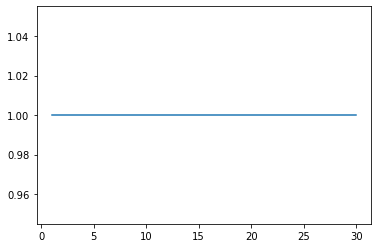

In [147]:
#The model is trained and the optimal max_depth for the Decision Tree is gotten.
md_scores = {}
for md in range(1,31):  
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = md)
    loanTree.fit(N_train, Z_train)
    md_scores[md] = loanTree.score(N_test, Z_test)
opt_md = list(md_scores.keys())[list(md_scores.values()).index(max(md_scores.values()))]
print(opt_md)
sns.lineplot(x = list(md_scores.keys()), y = list(md_scores.values()))

## Result and Discussion

- [Result]

The following classification algorithms; Decision Tree, K-Nearest Neighbours, and Logistic Regression, were tried on the dataset and the algorithm with the highest average predictive accuracy was the Decision Tree algorithm. After multiple experiments with a range of tree depth/levels (hyper parameters), the maximum predictive accuracy gotten from the Decision Tree model training was sitting between 90-100%. This value is represented in a range instead of a specific value due to the fact that the model is retrained with every schedule run.

This optimal model that emerged from the series of experiments was then used to run the inference on the new set of data gotten for the month of June, and predicted the Federal Fund Rates accurately. The predicted value is then loaded into the Database for future reference, trend checks and model assessment over time.

In [148]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = opt_md)
loanTree.fit(N_train,Z_train)
ln_pred = loanTree.predict(dataset_pred)
ln_pred = ln_pred.tolist()
#ln_pred
df = pd.DataFrame({'Date':pred_date, 'FOMC Pred.':ln_pred})
df

,Date,FOMC Pred.
0,2021-06-16,0.0025


Prediction before Federal Funds Rate was released for the current month.

In [152]:
selectQuery = 'select * from US_FOMC_PRED_VALUES'
pred_tab = pd.read_sql(selectQuery, pconn)
pred_tab

,DATE,PRED_VALUE


In [163]:
#The predicted value is loaded into the Database for future reference.
if pred_date in pred_tab['DATE'].values.tolist():
    pass
else:
    query = "INSERT INTO US_FOMC_PRED_VALUES VALUES('{}', '{}')".format(pred_date, ln_pred[0])
    %sql $query

In [164]:
selectQuery = 'select * from US_FOMC_PRED_VALUES'
pred_tab = pd.read_sql(selectQuery, pconn)
pred_tab

,DATE,PRED_VALUE
0,2021-06-16,0.0025


- [Further Discussion]

This phase of the project focused solely on the prediction of the Federal Fund Rate for the US Dollar, despite the fact that there are a host of other high impact inter-dependent news releases that are based on the US Dollar, and each major and minor currency (like the Canadian Dollar, Euros, Pounds, Australian and New Zealand Dollar, and so on) have their respective similar high impact news releases, all being released periodically. This is because all these predictions can be done quite easily by adopting the established program used for the US Dollar, for the rest of them. So focusing on the US Dollar Federal Funds Rate was simply for the purpose of breaking down a relatively difficult project into digestible chunks and easily targetable milestones, before scaling the results. Therefore, a further study or extension of this current project could cover a host of other high impact news releases, one might simply need to adjust the base algorithm, or even stack algorithms for higher accuracy.

Another not so obvious extension of this project is real-time market prediction. This is no different from the project carried out in this report. The underlying concept still simply entails extracting a couple of independent parameters from market historical data, doing some wrangling and then applying some supervised or unsupervised machine learning algorithm on the dataset to predict whichever detail about the market we find useful, and this could be a number of things like, market direction for the day (categorical), total pips moved in the market for the day (continuous numerical), and so on.

With further brainstorming, one could come up with many more areas of further study, hailing from the core concept behind the project covered in this report.

In [24]:
#Conection to IBM DB2 Database is terminated.
ibm_db.close(conn)

True

## Conclusion:

The purpose of this project was to predict a high impact economic news parameter, before its release, to help directly affected or interested persons to be able to react quickly to the impact of this news release and to also help those who seek to make long term projection with this news release. This was done by extracting data for each independent parameter for this prediction from an online website, cleaning and transforming this data, carrying out feature selection by using the correlation method, and loading this data into a database. This dataset is then called up from the database and use to inference purposes.

In a similar manner, this approach could be used for predicting a variety of other economic or market related parameter, for a host of reasons. This is the overall aim of this project. 